In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import detrend
from scipy.fft import fft
import ast

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Loading Data
data = pd.read_csv('userData.csv')
#convert string to list
data['rr'] = data['rr'].apply(ast.literal_eval)
data.head()

In [ ]:
type(data['rr'][6])

In [ ]:
# Create a list to store processed RR intervals for each row
processed_rr_list = []

for index, row in data.iterrows():
    rr_intervals = np.array(row['rr'])

    # 1. Artifact Correction
    mean_rr = np.mean(rr_intervals)
    std_rr = np.std(rr_intervals)
    artifact_threshold = 0.2  # 20%
    corrected_rr = rr_intervals[np.abs(rr_intervals - mean_rr) < artifact_threshold * std_rr]

    # Check if corrected_rr is empty
    if corrected_rr.size == 0:
        # Handle the empty array case (e.g., skip or use original data)
        # Example: Use original data
        processed_rr_list.append(rr_intervals.tolist())
        continue

    # 2. Detrending
    detrended_rr = detrend(corrected_rr)

    # 3. Normalization (Optional)
    #normalized_rr = (detrended_rr - np.mean(detrended_rr)) / np.std(detrended_rr)

    # Add the processed RR intervals to the list
    processed_rr_list.append(detrended_rr.tolist())

# Add the new column to the DataFrame
data['processed_rr'] = processed_rr_list

In [ ]:
data.head()

In [ ]:


# Function to interpolate RR intervals and apply FFT
def interpolate_and_fft(rr_intervals, sampling_rate=4):
    """
    Interpolates RR intervals to create an evenly spaced time series and then applies FFT.
    :param rr_intervals: list of RR intervals
    :param sampling_rate: the number of samples per second after interpolation
    :return: frequencies and magnitude of the FFT
    """
    # Time points (cumulative sum of RR intervals)
    time_points = np.cumsum(rr_intervals) / 1000.0  # convert to seconds

    # Interpolation
    duration = time_points[-1]
    interpolated_time = np.linspace(0, duration, int(duration * sampling_rate))
    interpolated_rr = interp1d(time_points, rr_intervals, kind='linear', fill_value='extrapolate')(interpolated_time)

    # FFT
    fft_result = fft(interpolated_rr)
    fft_freq = np.fft.fftfreq(len(interpolated_rr), d=1/sampling_rate)
    fft_magnitude = np.abs(fft_result)

    return fft_freq, fft_magnitude

# Apply to original and processed RR data
fft_results = []
for index, row in data.iterrows():
    # Original RR intervals
    original_rr = np.array(ast.literal_eval(row['rr']))
    freq, magnitude = interpolate_and_fft(original_rr)
    fft_results.append((freq, magnitude, 'Original'))

    # Processed RR intervals
    processed_rr = np.array(row['processed_rr'])
    freq, magnitude = interpolate_and_fft(processed_rr)
    fft_results.append((freq, magnitude, 'Processed'))

# Example: Plotting FFT of the first original and processed RR interval series
plt.figure(figsize=(12, 6))
#plt.plot(fft_results[0][0], fft_results[0][1], label='Original FFT')
plt.plot(fft_results[1][0], fft_results[1][1], label='Processed FFT')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('FFT of RR Intervals')
plt.legend()
plt.show()


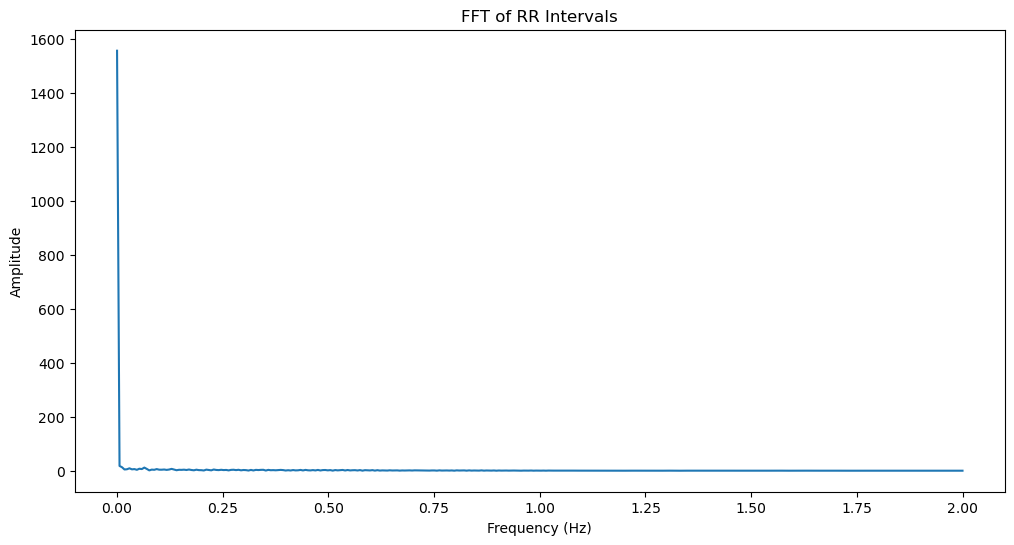

IndexError: boolean index did not match indexed array along dimension 0; dimension is 685 but corresponding boolean dimension is 342

In [9]:
import numpy as np
from scipy.fft import fft
import matplotlib.pyplot as plt

# RR intervals data
rr_intervals = np.array(
[753, 765, 778, 757, 768, 774, 775, 773, 777, 779, 807, 812, 830, 827, 816, 814, 805, 786, 784, 790, 787, 799, 804, 798, 802, 791, 797, 774, 787, 801, 817, 799, 810, 809, 797, 790, 802, 812, 812, 794, 802, 803, 806, 807, 794, 804, 786, 778, 792, 798, 790, 795, 790, 764, 762, 767, 771, 783, 772, 769, 766, 767, 757, 767, 782, 784, 787, 792, 808, 795, 808, 816, 824, 805, 809, 812, 808, 789, 796, 802, 785, 775, 790, 803, 782, 790, 805, 789, 788, 801, 805, 717, 818, 763, 758, 754, 609, 828, 848, 807, 755, 751, 747, 743, 744, 760, 767, 769, 775, 796, 794, 791, 797, 789, 801, 789, 806, 813, 797, 801, 802, 806, 790, 792, 799, 776, 777, 804, 794, 786, 786, 780, 774, 769, 783, 776, 773, 800, 793, 777, 791, 773, 764, 773, 771, 770, 768, 767, 771, 779, 786, 772, 765, 764, 766, 762, 767, 771, 762, 751, 756, 746, 672, 694, 715, 743, 785, 808, 792, 799, 800, 781, 760, 752, 747, 725, 731, 728, 746, 735, 731, 728, 726, 724, 714, 748, 756, 518, 780, 766, 759, 779, 786, 773, 780, 782, 794, 785, 785, 787, 764, 755, 739, 735, 725, 740, 755, 762, 764, 770, 789, 787, 790, 798, 807, 797, 798, 796, 789, 736]
)

# Interpolation
times = np.cumsum(rr_intervals) / 1000  # Convert to seconds
sampling_rate = 4  # Example sampling rate
desired_times = np.arange(0, times[-1], 1/sampling_rate)
interpolated_rr = np.interp(desired_times, times, rr_intervals)

# FFT
N = len(interpolated_rr)
T = 1.0 / sampling_rate
yf = fft(interpolated_rr)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

# Plotting the FFT spectrum
plt.figure(figsize=(12, 6))
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.title("FFT of RR Intervals")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.show()

# Extracting LF and HF
def extract_frequency_band_power(xf, yf, low_freq, high_freq):
    band_power = np.trapz(np.abs(yf[(xf >= low_freq) & (xf <= high_freq)]), x=xf[(xf >= low_freq) & (xf <= high_freq)])
    return band_power

lf_power = extract_frequency_band_power(xf, yf, 0.04, 0.15)
hf_power = extract_frequency_band_power(xf, yf, 0.15, 0.4)

lf_power, hf_power
